# NNDataset for training neural networks
A `NNDataset` is a collection of `MPPData`s (one for train/val/test). It is created using a parameter file defining its properties.

This notebooks shows:
- how to create a dataset from parameters
- how to iterate over an existing dataset


TODO add more info text 

In [9]:
import logging

logging.basicConfig(level=logging.INFO)

import os

from campa.data import NNDataset, create_dataset, load_example_data
from campa.utils import load_config
from campa.constants import SCRIPTS_DIR

# ensure that example data is downloaded
load_example_data()

## Create NNDataset
`NNDataset` is created with a config file that specifies from which folders to take the data and how to preprocess the data.

Here, we will use [params/example_data_params.py](params/example_data_params.py) to create an example dataset and save it to `DATASET_DIR/184A1_test_dataset`. 
Alternatively to this code, the `NNDataset` can also easily be created with the cli:
```
campa create_dataset $CAMPA_DIR/notebooks/params/example_data_params.py
```

This dataset uses data from two unperturbed and two meayamycin perturbed wells. It contains condition labels for the perturbation (one-hot-encoded) and for the cell cycle (one-hot-encoded). 
All cells are used, and 10% of all pixels. It is corrected for background fluorescence signal, and percentile-normalised.
It uses a neighborhood of 3x3 as inputs to the cVAE. 

In [10]:
config = load_config(os.path.join(SCRIPTS_DIR, "notebooks/params/example_data_params.py"))
config.data_params

{'dataset_name': '184A1_test_dataset',
 'data_config': 'TestData',
 'data_dirs': ['184A1_unperturbed/I09',
  '184A1_unperturbed/I11',
  '184A1_meayamycin/I12',
  '184A1_meayamycin/I20'],
 'channels': ['01_CDK9_pT186',
  '01_PABPC1',
  '02_CDK7',
  '03_CDK9',
  '03_RPS6',
  '05_GTF2B',
  '05_Sm',
  '07_POLR2A',
  '07_SETD1A',
  '08_H3K4me3',
  '09_CCNT1',
  '09_SRRM2',
  '10_H3K27ac',
  '10_POL2RA_pS2',
  '11_KPNA2_MAX',
  '11_PML',
  '12_RB1_pS807_S811',
  '12_YAP1',
  '13_PABPN1',
  '13_POL2RA_pS5',
  '14_PCNA',
  '15_SON',
  '15_U2SNRNPB',
  '16_H3',
  '17_HDAC3',
  '17_SRSF2',
  '18_NONO',
  '19_KPNA1_MAX',
  '20_ALYREF',
  '20_SP100',
  '21_COIL',
  '21_NCL',
  '00_DAPI',
  '07_H2B'],
 'condition': ['perturbation_duration_one_hot', 'cell_cycle_one_hot'],
 'condition_kwargs': {'cond_params': {}},
 'split_kwargs': {'train_frac': 0.7, 'val_frac': 0.2},
 'test_img_size': 225,
 'subset': True,
 'subset_kwargs': {'frac': None,
  'nona_condition': True,
  'cell_cycle': 'NO_NAN'},
 'subsam

In [11]:
create_dataset(config.data_params)

INFO:root:Creating train/val/test datasets with params:
INFO:root:{
    "dataset_name": "184A1_test_dataset",
    "data_config": "TestData",
    "data_dirs": [
        "184A1_unperturbed/I09",
        "184A1_unperturbed/I11",
        "184A1_meayamycin/I12",
        "184A1_meayamycin/I20"
    ],
    "channels": [
        "01_CDK9_pT186",
        "01_PABPC1",
        "02_CDK7",
        "03_CDK9",
        "03_RPS6",
        "05_GTF2B",
        "05_Sm",
        "07_POLR2A",
        "07_SETD1A",
        "08_H3K4me3",
        "09_CCNT1",
        "09_SRRM2",
        "10_H3K27ac",
        "10_POL2RA_pS2",
        "11_KPNA2_MAX",
        "11_PML",
        "12_RB1_pS807_S811",
        "12_YAP1",
        "13_PABPN1",
        "13_POL2RA_pS5",
        "14_PCNA",
        "15_SON",
        "15_U2SNRNPB",
        "16_H3",
        "17_HDAC3",
        "17_SRSF2",
        "18_NONO",
        "19_KPNA1_MAX",
        "20_ALYREF",
        "20_SP100",
        "21_COIL",
        "21_NCL",
        "00_DAPI",
  

FileNotFoundError: [Errno 2] No such file or directory: '/Users/hannah.spitzer/projects/pelkmans/software_new/campa/notebooks/example_data/raw/184A1_unperturbed/I09/metadata.csv'

## Use NNDataset

After creating the dataset, we can inspect it using `NNDataset`.

TODO: more comments + description here?

In [4]:
dataset_name = "184A1_test_dataset"
ds = NNDataset(dataset_name, data_config="TestData")

INFO:MPPData:Created new: MPPData for NascentRNA (50310 mpps with shape (3, 3, 34) from 35 objects). Data keys: ['x', 'y', 'obj_ids', 'mpp', 'labels', 'conditions'].
INFO:MPPData:Loaded data from /home/icb/hannah.spitzer/projects/pelkmans/software_new/campa/notebooks/example_data/datasets/184A1_test_dataset/train.
INFO:MPPData:Created new: MPPData for NascentRNA (12340 mpps with shape (3, 3, 34) from 8 objects). Data keys: ['x', 'y', 'obj_ids', 'mpp', 'labels', 'conditions'].
INFO:MPPData:Loaded data from /home/icb/hannah.spitzer/projects/pelkmans/software_new/campa/notebooks/example_data/datasets/184A1_test_dataset/val.
INFO:MPPData:Created new: MPPData for NascentRNA (4541 mpps with shape (3, 3, 34) from 3 objects). Data keys: ['x', 'y', 'obj_ids', 'mpp', 'labels', 'conditions'].
INFO:MPPData:Loaded data from /home/icb/hannah.spitzer/projects/pelkmans/software_new/campa/notebooks/example_data/datasets/184A1_test_dataset/test.
INFO:MPPData:Created new: MPPData for NascentRNA (123401 m

In [5]:
# dataset has attributes x and y (NN input + output)
# x is either mpp or mpp+condition
x = ds.x("val", is_conditional=False)
print(x.shape)

x, c = ds.x("train", is_conditional=True)
print(x.shape, c.shape)

(12340, 3, 3, 34)
(50310, 3, 3, 34) (50310, 14)


In [6]:
# dataset has data attributes with train/val/test data and img attribute with val/test image data.
# each split is represented as an MPPData object
print(ds.data["train"])

MPPData for NascentRNA (50310 mpps with shape (3, 3, 34) from 35 objects). Data keys: ['x', 'y', 'obj_ids', 'mpp', 'labels', 'conditions'].


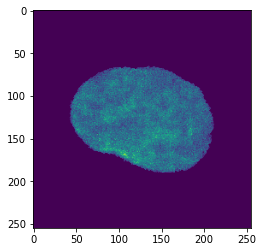

In [7]:
# ds.imgs contains the test and val image splits as MPPData objects
# we can plot images from the test_img / val_img split
import matplotlib.pyplot as plt

plt.imshow(ds.imgs["test"].get_object_img(ds.imgs["test"].obj_ids[0], channel_ids=0, img_size=255)[:, :, 0])

In [8]:
# dataset can returrn a tf dataset for using with e.g. keras
tf_ds = ds.get_tf_dataset(split="train", is_conditional=True)
print(tf_ds)

for x, y in tf_ds.take(1):
    print(x)
    print(y)

<FlatMapDataset shapes: (((3, 3, 34), (14,)), (34,)), types: ((tf.float32, tf.float32), tf.float32)>
(<tf.Tensor: shape=(3, 3, 34), dtype=float32, numpy=
array([[[0.0936107 , 0.26630774, 0.07320934, 0.15940166, 0.36546448,
         0.3404446 , 0.45454368, 0.37173337, 0.60624796, 0.3960421 ,
         0.8255608 , 0.3494866 , 0.39361078, 0.09944887, 0.26922902,
         0.59656715, 0.18625735, 0.04901129, 0.2675152 , 0.42029494,
         0.38429663, 0.72124416, 0.29912266, 0.09898952, 0.3727516 ,
         0.47532848, 0.26298115, 0.04432724, 0.485047  , 0.2930464 ,
         0.38888854, 0.01815833, 0.48511842, 0.01315851],
        [0.27191678, 0.5353282 , 0.07320934, 0.42257965, 0.61927867,
         0.0902684 , 0.43731877, 0.47501007, 0.60299385, 0.68134737,
         0.27898467, 0.59968406, 0.50128734, 0.05882251, 0.42537665,
         0.63191956, 0.15770498, 0.00224136, 0.29526088, 0.5331579 ,
         0.46299556, 0.91184646, 0.26879478, 0.03811043, 0.27625182,
         0.3237032 , 0.212152

2022-03-24 12:58:29.185523: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-24 12:58:29.247882: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
